In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os
import time
from sklearn.preprocessing import MinMaxScaler

In [2]:
# TRAINING_FILE = r'./dataset/IV_RRAM_TriD_17_2_SWEEP.csv'
# TRAINING_FILE = r'./dataset/12STO+3HfO2_TrainingSet.xlsx'
# TRAINING_FILE = r'./dataset/8STO+5AlN_TrainingSet.xlsx'

# TESTING_FILE = r'./dataset/IV_RRAM_RanD_17_2_SWEEP.csv'
# TESTING_FILE = r'./dataset/12STO+3HfO2_TestingSet.xlsx'
# TESTING_FILE = r'./dataset/8STO+5AlN_TestingSet.xlsx'

# DATA_DIRECTORY = r'./dataset/HfO2/'
DATA_DIRECTORY = r'./dataset/LSMO/unipolar 大概20次/'
# DATA_DIRECTORY = r'./dataset/STO/Bipolar compliance~1u/'
# DATA_DIRECTORY = r'./dataset/STO/unipolar 10次左右/'
# DATA_DIRECTORY = r'./dataset/STO/large area unipolar 50次/'

SEQ_LEN = 201
LSTM_layer = 0
Dense_layer = 2
Batch_size = 8
Epoch_number = 1000
Input_LEN = 2  # 2: take voltage and time step as input; 3: take voltage, time step and device number as input

In [3]:
seed_value = int(time.time() * 1000) % 1000
print('Random seed:', seed_value)

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

plt.close('all')
sns.set_theme(style='whitegrid')

Random seed: 300


In [4]:
# Function Definition

def log_scale(array):
    if type(array) == int or type(array) == np.float64:
        return np.log10(max(1e-14, abs(array)))
    if len(array.shape) <= 1:
        return np.log10(list(map(lambda x: max(1e-14, abs(x)), array)))
    return np.array(list(map(log_scale, array)))

min_max = {}
scaler = MinMaxScaler()
def importTrainingData(TRAINING_FILE: str, dataIsGroupByNumber = True) -> (np.array, np.array, np.array):
    print('Start importing training data')
    if '.csv' in TRAINING_FILE:
        df = pd.read_csv(TRAINING_FILE)
    elif '.xlsx' in TRAINING_FILE:
        df = pd.read_excel(TRAINING_FILE)

    if dataIsGroupByNumber:
        grouped = df.groupby('No')
        df = np.array([np.tile(item[1].values, (50, 1)) for item in grouped])
    else:
        df = np.tile(df.values.reshape(1, df.shape[0], df.shape[1]), (1, 2, 1))
    
    t_train = df[:, :, 0]  # no.
    w_train = df[:, :, 1]  # state
    v_train = df[:, :, 2]  # voltage
    i_train = df[:, :, 3]  # current
    if TRAINING_FILE == r'./dataset/IV_RRAM_TriD_17_2_SWEEP.csv':
        r_train = np.vstack([np.full(df.shape[0], 10), np.full(df.shape[0], 5), np.full(df.shape[0], 1)]).T  # time step
    else:
        r_train = np.ones(t_train.shape)  # time step

    i_train_log_scale = log_scale(i_train)

    # keep minimum and maximum value to de-normalise later
    min_max['t'] = ({'min': np.min(t_train), 'max': np.max(t_train)})
    min_max['v'] = ({'min': np.min(v_train), 'max': np.max(v_train)})
    min_max['i'] = ({'min': np.min(i_train_log_scale), 'max': np.max(i_train_log_scale)})

    # normalization
    t_train = [list(map(lambda t: (t - min_max['t']['min']) / (min_max['t']['max'] - min_max['t']['min']), x)) for x in t_train]
    v_train = [list(map(lambda v: (v - min_max['v']['min']) / (min_max['v']['max'] - min_max['v']['min']), x)) for x in v_train]
    i_train = [list(map(lambda i: (i - min_max['i']['min']) / (min_max['i']['max'] - min_max['i']['min']), x)) for x in i_train]
    i_train_log_scale = [list(map(lambda i: (i - min_max['i']['min']) / (min_max['i']['max'] - min_max['i']['min']), x)) for x in i_train_log_scale]

    # X includes time, state, voltage and time_step
    # y includes state and current
    X_train = []
    y_train = []
    for t, w, v, i, r in zip(t_train, w_train, v_train, i_train_log_scale, r_train):
        for j in range(len(t) - SEQ_LEN):
            x_train = np.vstack((t[j: j + SEQ_LEN], w[j: j + SEQ_LEN], v[j: j + SEQ_LEN], r[j: j + SEQ_LEN])).T
            X_train.append(x_train)
            y_train.append(i[j + SEQ_LEN - 1: j + SEQ_LEN])
    X_train = np.array(X_train)
    w_train = w_train[:, SEQ_LEN: ].reshape(-1, 1)
    y_train = np.array(y_train)

    print('Done')
    return (X_train, w_train, y_train)

def importTestingData(TESTING_FILE: str) -> (np.array, np.array, np.array):
    print('Start importing testing file')
    if '.csv' in TESTING_FILE:
        df = pd.read_csv(TESTING_FILE)
    elif '.xlsx' in TESTING_FILE:
        df = pd.read_excel(TESTING_FILE)

    grouped = df.groupby('No')
    df = np.array([np.tile(item[1].values, (2, 1)) for item in grouped])
    t_test = df[:, :, 0]
    w_test = df[:, :, 1]
    v_test = df[:, :, 2]
    i_test = df[:, :, 3]
    if TESTING_FILE == r'./dataset/IV_RRAM_RanD_17_2_SWEEP.csv':
        r_test = np.vstack([np.full(df.shape[0], 10), np.full(df.shape[0], 5), np.full(df.shape[0], 1)]).T
    else:
        r_test = np.ones(t_test.shape)
    i_test_log_scale = log_scale(i_test)

    t_test = [list(map(lambda t: (t - min_max['t']['min']) / (min_max['t']['max'] - min_max['t']['min']), x)) for x in t_test]
    v_test = [list(map(lambda v: (v - min_max['v']['min']) / (min_max['v']['max'] - min_max['v']['min']), x)) for x in v_test]
    i_test = [list(map(lambda i: (i - min_max['i']['min']) / (min_max['i']['max'] - min_max['i']['min']), x)) for x in i_test]
    i_test_log_scale = [list(map(lambda i: (i - min_max['i']['min']) / (min_max['i']['max'] - min_max['i']['min']), x)) for x in i_test_log_scale]

    # X includes time, state, current and time_step
    # y includes voltage
    X_test = []
    y_test = []
    for t, w, v, i, r in zip(t_test, w_test, v_test, i_test_log_scale, r_test):
        for j in range(len(t) - SEQ_LEN):
            x_test = np.vstack((t[j: j + SEQ_LEN], w[j: j + SEQ_LEN], v[j: j + SEQ_LEN], r[j: j + SEQ_LEN])).T
            X_test.append(x_test)
            y_test.append(i[j + SEQ_LEN - 1: j + SEQ_LEN])
    X_test = np.array(X_test)
    w_test = w_test[:, SEQ_LEN: ].reshape(-1, 1)
    y_test = np.array(y_test)

    print('Done')
    return X_test, w_test, y_test

def importTrainingAndTestingData(DATA_DIRECTORY: str, excludeFirstLine = True):
    print('Start importing data')
    # fileList = list(x for x in os.listdir(DATA_DIRECTORY) if ('Set' in x or 'Reset' in x) and '.csv' in x and 'fail' not in x)
    fileList = list(x for x in os.listdir(DATA_DIRECTORY) if ('Set' in x) and '.csv' in x and 'fail' not in x)
    # fileList = list(x for x in os.listdir(DATA_DIRECTORY) if ('Reset' in x and 'ResetDC' not in x) and '.csv' in x and 'fail' not in x)
    print(fileList)
    
    trainingList = fileList[-10:]
    testingList = fileList[-4:]
    
    trainingData = np.full((SEQ_LEN - 1, 3), [0, -14, 0])
    for count, file in enumerate(trainingList, 1):
        df = pd.read_csv(DATA_DIRECTORY + file, on_bad_lines='skip')
        df.columns = ['Vd','Id']
        index = df[((df.Vd == 'V1') & (df.Id == 'I1'))].index.values
        if index >= 0:
            df.drop([i for i in range(index[0] + 1)], inplace=True)
            df = df.reset_index().drop(columns = 'index')
            df.Vd = pd.to_numeric(df.Vd)
            df.Id = pd.to_numeric(df.Id)
        df.Id = df.apply(lambda x: np.log10(max(1e-14, abs(x.Id))), axis = 1)
        df.insert(2, 'No', count)
        trainingData = np.concatenate((trainingData, df.values), axis = 0)
        
    
    scaler.fit(trainingData)
    trainingData = pd.DataFrame(scaler.transform(trainingData), columns = ['Vd', 'Id', 'No'])
    trainingData.insert(3, 'Time Step', 0.5)
    
    testingData = np.full((SEQ_LEN - 1, 3), [0, -14, 0])
    for count, file in enumerate(testingList, len(trainingList)):
        df = pd.read_csv(DATA_DIRECTORY + file, on_bad_lines='skip')
        df.columns = ['Vd','Id']
        index = df[((df.Vd == 'V1') & (df.Id == 'I1'))].index.values
        if index >= 0:
            df.drop([i for i in range(index[0] + 1)], inplace=True)
            df = df.reset_index().drop(columns = 'index')
            df.Vd = pd.to_numeric(df.Vd)
            df.Id = pd.to_numeric(df.Id)
        df.Id = df.apply(lambda x: log_scale(x.Id), axis = 1)
        df.insert(2, 'No', count)
        testingData = np.concatenate((testingData, df.values), axis = 0)
    
    testingData = pd.DataFrame(scaler.transform(testingData), columns = ['Vd', 'Id', 'No'])
    testingData.insert(3, 'Time Step', 0.5)
    
#     t_train = np.vstack([trainingData['Time Step'].shift(-i).values for i in range(SEQ_LEN)])[:, :-SEQ_LEN + 1].T
#     c_train = np.vstack([trainingData['No'].shift(-i).values for i in range(SEQ_LEN)])[:, :-SEQ_LEN + 1].T
#     v_train = np.vstack([trainingData['Vd'].shift(-i).values for i in range(SEQ_LEN)])[:, :-SEQ_LEN + 1].T
#     i_train = trainingData['Id'].shift(-SEQ_LEN + 1).values[:-SEQ_LEN + 1].T
    
#     t_test = np.vstack([testingData['Time Step'].shift(-i).values for i in range(SEQ_LEN)])[:, :-SEQ_LEN + 1].T
#     c_test = np.vstack([testingData['No'].shift(-i).values for i in range(SEQ_LEN)])[:, :-SEQ_LEN + 1].T
#     v_test = np.vstack([testingData['Vd'].shift(-i).values for i in range(SEQ_LEN)])[:, :-SEQ_LEN + 1].T
#     i_test = testingData['Id'].shift(-SEQ_LEN + 1).values[:-SEQ_LEN + 1].T
    
    t_train = trainingData['Time Step'].values.T
    c_train = trainingData['No'].values.T
    v_train = trainingData['Vd'].values.T
    i_train = trainingData['Id'].values.T
    
    t_test = testingData['Time Step'].values.T
    c_test = testingData['No'].values.T
    v_test = testingData['Vd'].values.T
    i_test = testingData['Id'].values.T
    
    X_train = np.stack((v_train, t_train, c_train), axis = -1)
    X_test = np.stack((v_test, t_test, c_test), axis = -1)
    y_train = i_train[:]
    y_test = i_test[:]
    
    print('Done')
    return X_train, y_train, X_test, y_test, trainingData, testingData

Start importing data
['4_3_2024 3_05_17 PM  [(1) Set; ].csv', '4_3_2024 3_05_52 PM  [(1) Set; ].csv', '4_3_2024 3_06_20 PM  [(2) Set; ].csv', '4_3_2024 3_06_51 PM  [(3) Set; ].csv', '4_3_2024 3_07_17 PM  [(4) Set; ].csv', '4_3_2024 3_07_43 PM  [(5) Set; ].csv', '4_3_2024 3_08_09 PM  [(6) Set; ].csv', '4_3_2024 3_08_35 PM  [(7) Set; ].csv', '4_3_2024 3_09_01 PM  [(8) Set; ].csv', '4_3_2024 3_09_25 PM  [(9) Set; ].csv', '4_3_2024 3_09_49 PM  [(10) Set; ].csv', '4_3_2024 3_10_16 PM  [(11) Set; ].csv', '4_3_2024 3_10_44 PM  [(12) Set; ].csv', '4_3_2024 3_11_10 PM  [(13) Set; ].csv', '4_3_2024 3_11_36 PM  [(14) Set; ].csv', '4_3_2024 3_12_02 PM  [(15) Set; ].csv', '4_3_2024 3_12_28 PM  [(16) Set; ].csv', '4_3_2024 3_12_52 PM  [(17) Set; ].csv', '4_3_2024 3_13_16 PM  [(18) Set; ].csv', '4_3_2024 3_13_41 PM  [(19) Set; ].csv', '4_3_2024 3_15_50 PM  [(1) Set; ].csv', '4_3_2024 3_16_15 PM  [(2) Set; ].csv', '4_3_2024 3_16_39 PM  [(3) Set; ].csv', '4_3_2024 3_17_06 PM  [(4) Set; ].csv', '4_3_202

E:\Anaconda\envs\DL\lib\site-packages\ipykernel_launcher.py:118: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
E:\Anaconda\envs\DL\lib\site-packages\ipykernel_launcher.py:137: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


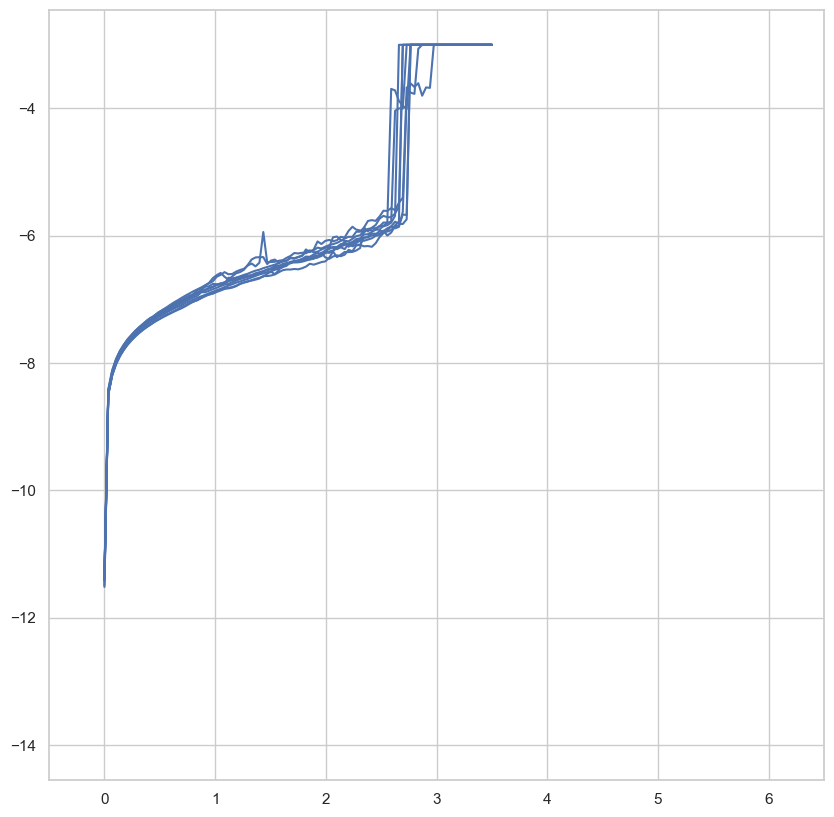

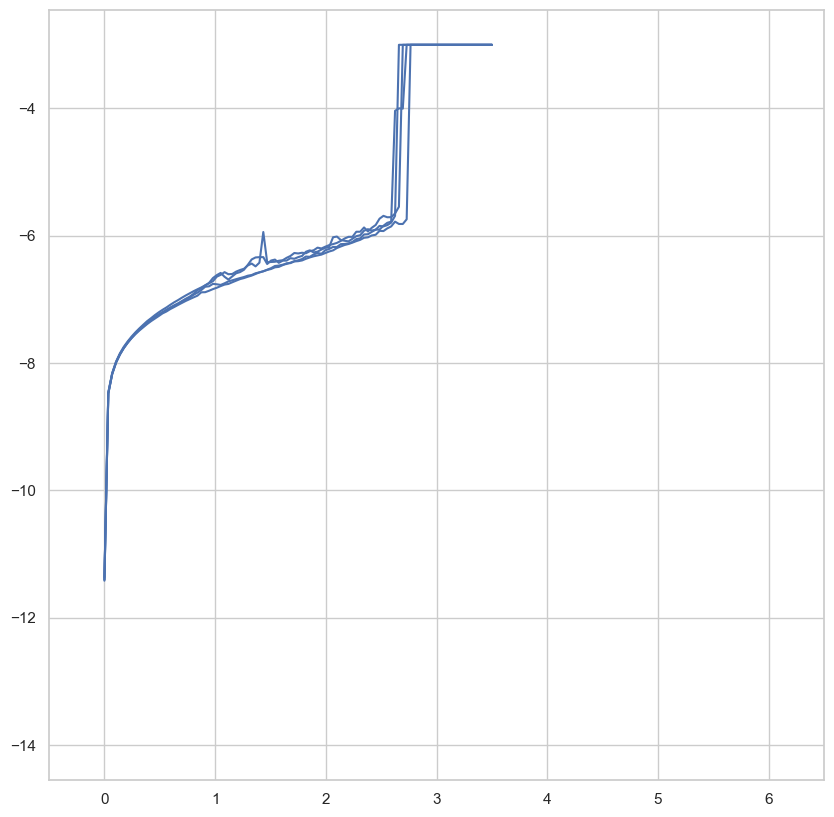

In [5]:
# X_train, w_train, y_train = importTrainingData(TRAINING_FILE)
# X_test, w_test, y_test = importTestingData(TESTING_FILE)

X_train, y_train, X_test, y_test, trainingData, testingData = importTrainingAndTestingData(DATA_DIRECTORY)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

trainingData = scaler.inverse_transform(trainingData.values[:, :3])
trainingData = pd.DataFrame(trainingData, columns = ['Vd', 'Id', 'No'])

testingData = scaler.inverse_transform(testingData.values[:, :3])
testingData = pd.DataFrame(testingData, columns = ['Vd', 'Id', 'No'])

fig, ax = plt.subplots(figsize = (10, 10))
ax.set_xlim(-0.5, 6.5)
for i in trainingData.No.unique():
    plt.plot(trainingData[trainingData.No == i].Vd.abs(), trainingData[trainingData.No == i].Id, c = 'b')
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
ax.set_xlim(-0.5, 6.5)
for i in testingData.No.unique():
    plt.plot(testingData[testingData.No == i].Vd.abs(), testingData[testingData.No == i].Id, c = 'b')
plt.show()

In [6]:
# # build LSTM model

# def create_model(LSTM_layer = LSTM_layer, Dense_layer = Dense_layer, Input_shape = (Input_LEN)):
#     X_seq = tf.keras.Input(shape = (Input_LEN), name = "Time, State, Voltage and TimeStep")
#     layer = tf.keras.layers.Concatenate([X_seq])
    
#     for _ in range(LSTM_layer - 1):
#         layer = tf.keras.layers.LSTM(units = 10, input_shape = Input_shape, return_sequences = True)(layer)
    
#     if (LSTM_layer > 0):
#         layer = tf.keras.layers.LSTM(units = 10, input_shape = Input_shape, return_sequences = False)(layer)
    
#     for _ in range(Dense_layer):
#         layer = tf.keras.layers.Dense(units = 20, activation = 'tanh')(layer)
        
#     layer = tf.keras.layers.Dense(units = 1, name = 'output_y')(layer)
    
#     # LSTM_w_next = tf.keras.layers.LSTM(units = 10, input_shape = (SEQ_LEN, Input_LEN), return_sequences = False)(X_seq)
#     # LSTM_w_next = tf.keras.layers.Dense(units = 10)(LSTM_w_next)
#     # LSTM_w_next = tf.keras.layers.Dense(units = 2, activation='sigmoid',name='LSTM_output_w')(LSTM_w_next)
#     # return tf.keras.Model(inputs = [X_seq], outputs=[LSTM_w_next, LSTM_y_next])
    
#     return tf.keras.Model(inputs = [X_seq], outputs = [layer])
# #     return model

# model = create_model(LSTM_layer, Dense_layer, (Input_LEN) if LSTM_layer == 0 else (SEQ_LEN, Input_LEN))
# # model.compile(optimizer = 'adam', loss = ['sparse_categorical_crossentropy', 'mse'], loss_weights = [0.1, 0.9], metrics = ['accuracy', 'mse'])
# model.compile(optimizer = 'adam', loss = ['mse'], metrics = ['mse'])
# callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', mode = 'min', patience = 300, verbose = 1, restore_best_weights = True)
# model.summary()

def create_model(SEQ_LEN = SEQ_LEN, LSTM_layer = LSTM_layer, Dense_layer = Dense_layer, Input_LEN = Input_LEN):
    X_seq = tf.keras.Input(shape = (Input_LEN), name = "Time, State, Voltage and TimeStep")

    if LSTM_layer == 1 and Dense_layer == 1:
        LSTM_y_next = tf.keras.layers.LSTM(units = 10, input_shape = (SEQ_LEN, Input_LEN), activation='tanh', recurrent_activation='sigmoid', return_sequences = False)(X_seq)
        LSTM_y_next = tf.keras.layers.Dense(units = 20, activation = 'relu')(LSTM_y_next)
        LSTM_y_next = tf.keras.layers.Dense(units = 1, name='LSTM_output_y')(LSTM_y_next)
    elif LSTM_layer == 2 and Dense_layer == 0:
        LSTM_y_next = tf.keras.layers.LSTM(units = 10, input_shape = (SEQ_LEN, Input_LEN), activation='tanh', recurrent_activation='sigmoid', return_sequences = True)(X_seq)
        LSTM_y_next = tf.keras.layers.LSTM(units = 10, input_shape = (10, Input_LEN), activation='tanh', recurrent_activation='sigmoid', return_sequences = False)(LSTM_y_next)
        LSTM_y_next = tf.keras.layers.Dense(units = 1,name='LSTM_output_y')(LSTM_y_next)
    elif LSTM_layer == 1 and Dense_layer == 2:
        LSTM_y_next = tf.keras.layers.LSTM(units = 10, input_shape = (SEQ_LEN, Input_LEN), activation='tanh', recurrent_activation='sigmoid', return_sequences = False)(X_seq)
        LSTM_y_next_tanh = tf.keras.layers.Dense(units = 10, activation = 'tanh')(LSTM_y_next)
        LSTM_y_next_ReLU = tf.keras.layers.Dense(units = 10, activation = 'relu')(LSTM_y_next)
        LSTM_y_next = tf.keras.layers.Concatenate(axis=1)([LSTM_y_next_tanh, LSTM_y_next_ReLU])
        LSTM_y_next_tanh = tf.keras.layers.Dense(units = 10, activation = 'tanh')(LSTM_y_next)
        LSTM_y_next_ReLU = tf.keras.layers.Dense(units = 10, activation = 'relu')(LSTM_y_next)
        LSTM_y_next = tf.keras.layers.Concatenate(axis=1)([LSTM_y_next_tanh, LSTM_y_next_ReLU])
        LSTM_y_next = tf.keras.layers.Dense(units = 1,name='LSTM_output_y')(LSTM_y_next)
    elif LSTM_layer == 0 and Dense_layer == 2:
        LSTM_y_next_tanh = tf.keras.layers.Dense(units = 20, activation = 'tanh')(X_seq)
        LSTM_y_next_ReLU = tf.keras.layers.Dense(units = 20, activation = 'relu')(X_seq)
        LSTM_y_next = tf.keras.layers.Concatenate(axis=1)([LSTM_y_next_tanh, LSTM_y_next_ReLU])
        LSTM_y_next_tanh = tf.keras.layers.Dense(units = 20, activation = 'tanh')(LSTM_y_next)
        LSTM_y_next_ReLU = tf.keras.layers.Dense(units = 20, activation = 'relu')(LSTM_y_next)
        LSTM_y_next = tf.keras.layers.Concatenate(axis=1)([LSTM_y_next_tanh, LSTM_y_next_ReLU])
        LSTM_y_next = tf.keras.layers.Dense(units = 1,name='LSTM_output_y')(LSTM_y_next)
    else:
        raise
        
    # LSTM_w_next = tf.keras.layers.LSTM(units = 10, input_shape = (SEQ_LEN, Input_LEN), return_sequences = False)(X_seq)
    # LSTM_w_next = tf.keras.layers.Dense(units = 10)(LSTM_w_next)
    # LSTM_w_next = tf.keras.layers.Dense(units = 2, activation='sigmoid',name='LSTM_output_w')(LSTM_w_next)
    # return tf.keras.Model(inputs = [X_seq], outputs=[LSTM_w_next, LSTM_y_next])
    
    return tf.keras.Model(inputs = [X_seq], outputs = [LSTM_y_next])

model = create_model(SEQ_LEN, LSTM_layer, Dense_layer)
# model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[0.1, 0.9], metrics=['accuracy','mse'])
model.compile(optimizer='adam', loss=['mse'], metrics=['mse'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=300, verbose=1, restore_best_weights=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Time, State, Voltage and TimeS  [(None, 2)]         0           []                               
 tep (InputLayer)                                                                                 
                                                                                                  
 dense (Dense)                  (None, 20)           60          ['Time, State, Voltage and TimeSt
                                                                 ep[0][0]']                       
                                                                                                  
 dense_1 (Dense)                (None, 20)           60          ['Time, State, Voltage and TimeSt
                                                                 ep[0][0]']                   

In [7]:
init_time = time.time()
# with tf.device('/gpu:0'):

hist = model.fit(# x = X_train if X_train.shape[2] == Input_LEN else X_train[:, :, :Input_LEN],
                 x = X_train if X_train.shape[1] == Input_LEN else X_train[:, :Input_LEN],
                 # y = [w_train, y_train],
                 y = y_train,
                 batch_size = Batch_size,
                 epochs = Epoch_number,
                 shuffle = True,
                 verbose = 1,
                 callbacks = [callback],
                 validation_split = 0.2
                )

hist = pd.DataFrame(hist.history)
print('Time used =', time.strftime("%H:%M:%S", time.gmtime(time.time() - init_time)))

Epoch 1/1000
113/113 [==============================] - 4s 7ms/step - loss: 0.1068 - mse: 0.1068 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 2/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 3/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 4/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 5/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 6/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 8/1000
113/113 [==============================] - 0s 4ms

Epoch 62/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 63/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 64/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 65/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 66/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 67/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 68/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 69/1000
113/113 [==============================] 

113/113 [==============================] - 1s 5ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 123/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 124/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 125/1000
113/113 [==============================] - 1s 6ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 126/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 127/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 128/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 129/1000
113/113 [==============================] - 0s 4m

113/113 [==============================] - 0s 4ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 183/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 184/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 185/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 186/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 187/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 188/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 189/1000
113/113 [==============================] - 1s 5m

113/113 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 243/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 244/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 245/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 246/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 247/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 248/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 249/1000
113/113 [==============================] - 1s 5m

113/113 [==============================] - 1s 5ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 303/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 9.7113e-04 - val_mse: 9.7113e-04
Epoch 304/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 305/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 306/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 307/1000
113/113 [==============================] - 1s 6ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 308/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 309/1000
113/113 [==============================]

113/113 [==============================] - 1s 5ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 7.1320e-04 - val_mse: 7.1320e-04
Epoch 363/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 364/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 365/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 366/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 367/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 368/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 369/1000
113/113 [==============================]

113/113 [==============================] - 1s 4ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 423/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 424/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 425/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 426/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 427/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 428/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 429/1000
113/113 [==============================] - 1s 5m

113/113 [==============================] - 1s 5ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 483/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 484/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 485/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 486/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 487/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 488/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 489/1000
113/113 [==============================] - 1s 5m

113/113 [==============================] - 1s 4ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 543/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 544/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 545/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 546/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 547/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 9.7740e-04 - val_mse: 9.7740e-04
Epoch 548/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 549/1000
113/113 [==============================]

Epoch 602/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 603/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 604/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 605/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 606/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 607/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 608/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 609/1000
113/113 [========================

113/113 [==============================] - 1s 5ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 663/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 664/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 665/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 666/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 667/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 668/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 669/1000
113/113 [==============================] - 1s 5m

113/113 [==============================] - 1s 5ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 723/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 724/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 725/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 726/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 727/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 728/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 729/1000
113/113 [==============================] - 0s 4m

113/113 [==============================] - 1s 4ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 783/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 784/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 785/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 786/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 787/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 788/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 789/1000
113/113 [==============================] - 1s 5m

113/113 [==============================] - 1s 5ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 843/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 844/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 845/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 846/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 6.8863e-04 - val_mse: 6.8863e-04
Epoch 847/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 848/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 849/1000
113/113 [==============================]

113/113 [==============================] - 1s 5ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 903/1000
113/113 [==============================] - 0s 4ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 904/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 905/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 906/1000
113/113 [==============================] - 1s 6ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 907/1000
113/113 [==============================] - 1s 5ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 908/1000
113/113 [==============================] - 1s 4ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 909/1000
113/113 [==============================] - 1s 5m

In [8]:
weights = model.get_weights()
# model.save(f'{TRAINING_FILE[10:19]}_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_save.h5')
# model.save_weights(f'{TRAINING_FILE[10:19]}_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_weights.h5')
if 'HfO2' in DATA_DIRECTORY:
    print(f'HfO2_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen')
    model.save(f'HfO2_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen_save.h5')
    model.save_weights(f'HfO2_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen_weights.h5')
elif 'LSMO' in DATA_DIRECTORY:
    print(f'LSMO_Unipolar20_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen')
    model.save(f'LSMO_Unipolar20_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen_save.h5')
    model.save_weights(f'LSMO_Unipolar20_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen_weights.h5')
elif '1u' in DATA_DIRECTORY:
    print(f'STO_Bipolar_1u_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen')
    model.save(f'STO_Bipolar_1u_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen_save.h5')
    model.save_weights(f'STO_Bipolar_1u_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen_weights.h5')
elif '50次' in DATA_DIRECTORY:
    print(f'STO_Unipolar50_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen')
    model.save(f'STO_Unipolar50_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen_save.h5')
    model.save_weights(f'STO_Unipolar50_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen_weights.h5')
elif '10次' in DATA_DIRECTORY:
    print(f'STO_Unipolar10_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen')
    model.save(f'STO_Unipolar10_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen_save.h5')
    model.save_weights(f'STO_Unipolar10_{SEQ_LEN}SeqLen_{LSTM_layer}LSTMLayer_{Dense_layer}DenseLayer_{Input_LEN}InputLen_weights.h5')

for i, weight_matrix in enumerate(weights):
    np.savetxt(f"weight_{i}.csv", weight_matrix, delimiter=",")

LSMO_Unipolar20_0LSTMLayer_2DenseLayer_2InputLen


In [9]:
# # Load archive
# model = tf.keras.models.load_model('8STO+5AlN_100SeqLen_1LSTMLayer_1DenseLayer_save.h5')
# 
# # 驗證模型
# score_train = model.evaluate(X_train, [w_train, y_train])
# score_test = model.evaluate(X_test, [w_test, y_test])
# 
# # 輸出結果
# print('Train loss:', score_train[2])
# print('Train accuracy:', score_train[5])
# print('Test loss:', score_test[2])
# print('Test accuracy:', score_test[5])

In [10]:
# y_train_pred = model.predict(x = X_train if X_train.shape[2] == Input_LEN else X_train[:, :, :Input_LEN])
# y_test_pred = model.predict(x = X_test if X_test.shape[2] == Input_LEN else X_test[:, :, :Input_LEN])
# trainingData_pred = np.hstack((X_train[:, -1, 0].reshape(-1, 1), y_train_pred, X_train[:, -1, 2].reshape(-1, 1)))
# testingData_pred = np.hstack((X_test[:, -1, 0].reshape(-1, 1), y_test_pred, X_test[:, -1, 2].reshape(-1, 1)))

y_train_pred = model.predict(x = X_train if X_train.shape[1] == Input_LEN else X_train[:, :Input_LEN])
y_test_pred = model.predict(x = X_test if X_test.shape[1] == Input_LEN else X_test[:, :Input_LEN])
trainingData_pred = np.hstack((X_train[:, 0].reshape(-1, 1), y_train_pred, X_train[:, 2].reshape(-1, 1)))
testingData_pred = np.hstack((X_test[:, 0].reshape(-1, 1), y_test_pred, X_test[:, 2].reshape(-1, 1)))

trainingData_pred = scaler.inverse_transform(trainingData_pred)
testingData_pred =scaler.inverse_transform(testingData_pred)

trainingData_pred = pd.DataFrame(trainingData_pred, columns = ['Vd', 'Id', 'No'])
testingData_pred = pd.DataFrame(testingData_pred, columns = ['Vd', 'Id', 'No'])

19/19 [==============================] - 0s 2ms/step


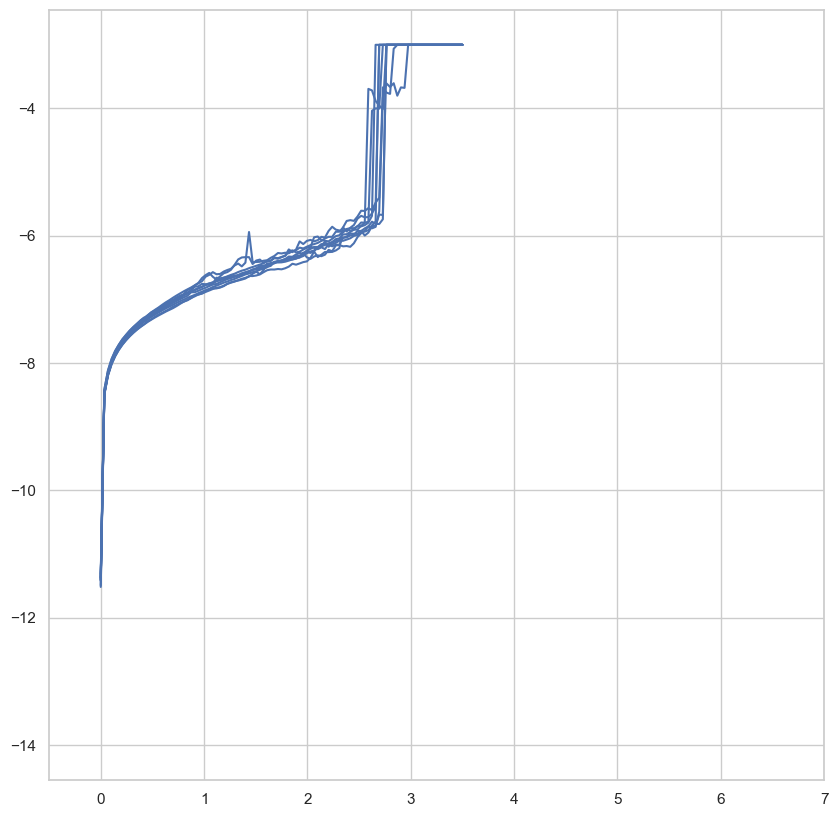

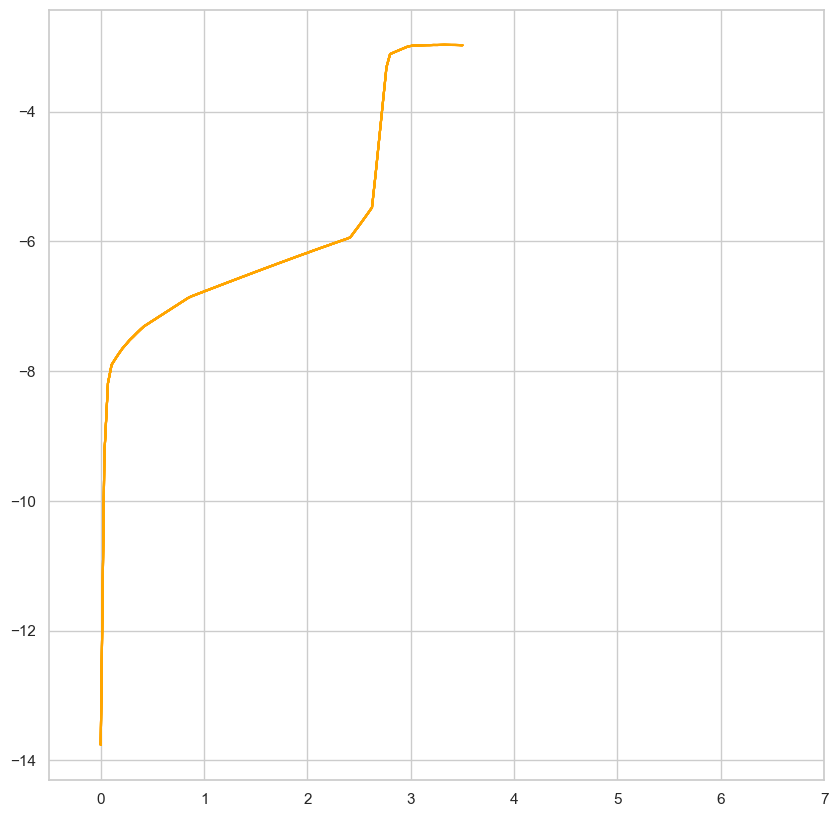

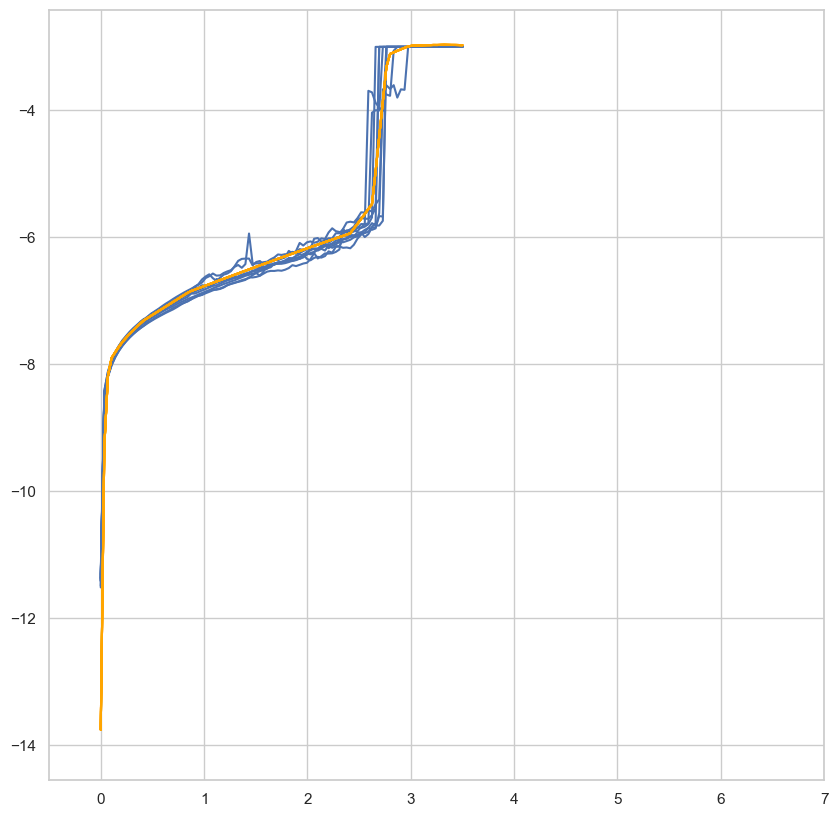

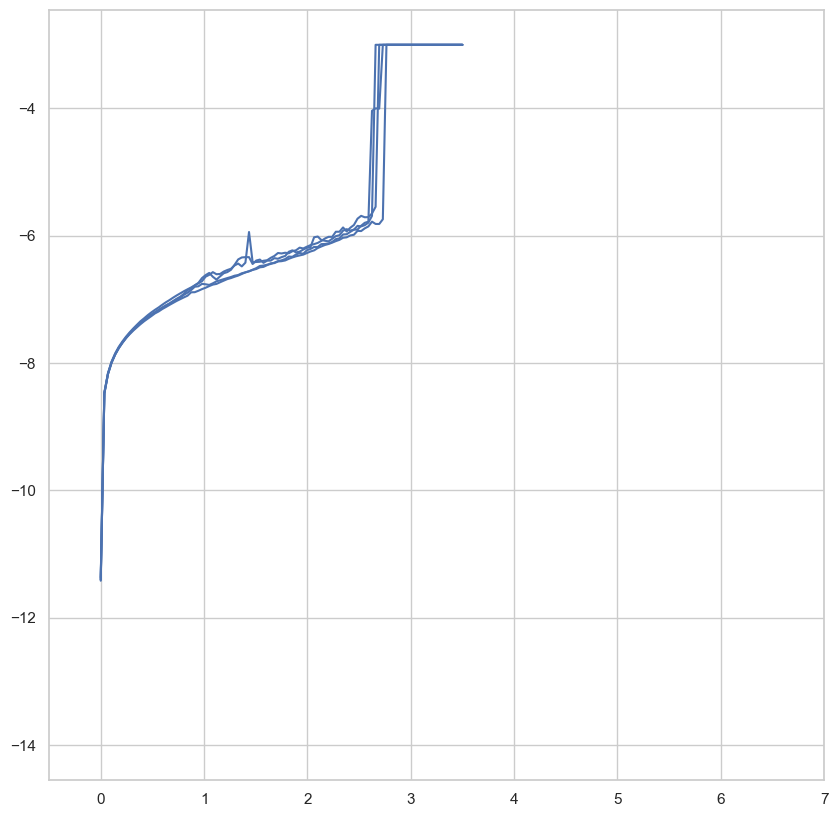

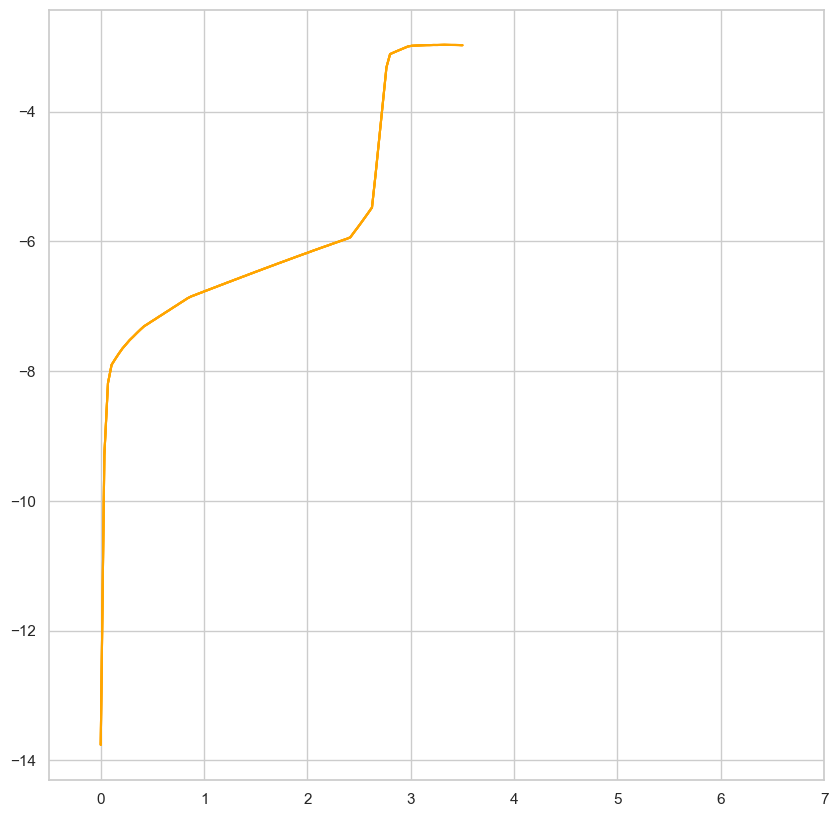

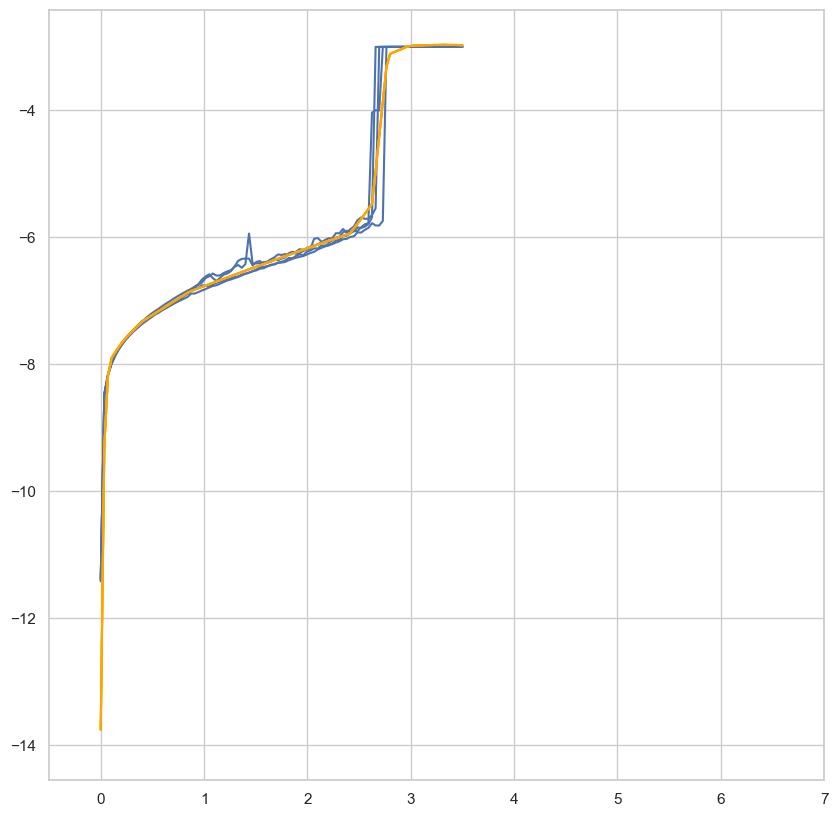

In [11]:
# fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 15), sharex = True, sharey = True)
# ax[0].set_ylim(-13, -2)
# plt.subplot(311)
# for i in trainingData.No.unique():
#     plt.plot('Vd', 'Id', data = trainingData[trainingData.No == i], c = 'b')
# plt.subplot(312)
# for i in trainingData_pred.No.unique():
#     plt.plot('Vd', 'Id', data = trainingData_pred[trainingData_pred.No == i], c = 'orange')
# plt.subplot(313)
# for i in trainingData.No.unique():
#     plt.plot('Vd', 'Id', data = trainingData[trainingData.No == i], c = 'b')
# for i in trainingData_pred.No.unique():
#     plt.plot('Vd', 'Id', data = trainingData_pred[trainingData_pred.No == i], c = 'orange')
# plt.show()

# fig, ax= plt.subplots(nrows = 3, ncols = 1, figsize = (10, 15), sharex = True, sharey = True)
# ax[0].set_ylim(-13, -2)
# plt.subplot(311)
# for i in testingData.No.unique():
#     plt.plot('Vd', 'Id', data = testingData[testingData.No == i], c = 'b')
# plt.subplot(312)
# for i in testingData.No.unique():
#     plt.plot('Vd', 'Id', data = testingData_pred[testingData_pred.No == i], c = 'orange')
# plt.subplot(313)
# for i in testingData.No.unique():
#     plt.plot('Vd', 'Id', data = testingData[testingData.No == i], c = 'b')
# for i in testingData.No.unique():
#     plt.plot('Vd', 'Id', data = testingData_pred[testingData_pred.No == i], c = 'orange')
# plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), sharex = True, sharey = True)
ax.set_xlim(-0.5, 7)
plt.subplot(111)
for i in trainingData.No.unique():
    plt.plot(trainingData[trainingData.No == i].Vd.abs(), trainingData[trainingData.No == i].Id, c = 'b')
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), sharex = True, sharey = True)
ax.set_xlim(-0.5, 7)
plt.subplot(111)
for i in trainingData_pred.No.unique():
    plt.plot(trainingData_pred[trainingData_pred.No == i].Vd.abs(), trainingData_pred[trainingData_pred.No == i].Id, c = 'orange')
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), sharex = True, sharey = True)
ax.set_xlim(-0.5, 7)
plt.subplot(111)
for i in trainingData.No.unique():
    plt.plot(trainingData[trainingData.No == i].Vd.abs(), trainingData[trainingData.No == i].Id, c = 'b')
for i in trainingData_pred.No.unique():
    plt.plot(trainingData_pred[trainingData_pred.No == i].Vd.abs(), trainingData_pred[trainingData_pred.No == i].Id, c = 'orange')
plt.show()

fig, ax= plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), sharex = True, sharey = True)
ax.set_xlim(-0.5, 7)
plt.subplot(111)
for i in testingData.No.unique():
    plt.plot(testingData[testingData.No == i].Vd.abs(), testingData[testingData.No == i].Id, c = 'b')
plt.show()

fig, ax= plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), sharex = True, sharey = True)
ax.set_xlim(-0.5, 7)
plt.subplot(111)
for i in testingData_pred.No.unique():
    plt.plot(testingData_pred[testingData_pred.No == i].Vd.abs(), testingData_pred[testingData_pred.No == i].Id, c = 'orange')
plt.show()

fig, ax= plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), sharex = True, sharey = True)
ax.set_xlim(-0.5, 7)
plt.subplot(111)
for i in testingData.No.unique():
    plt.plot(testingData[testingData.No == i].Vd.abs(), testingData[testingData.No == i].Id, c = 'b')
for i in testingData_pred.No.unique():
    plt.plot(testingData_pred[testingData_pred.No == i].Vd.abs(), testingData_pred[testingData_pred.No == i].Id, c = 'orange')
plt.show()

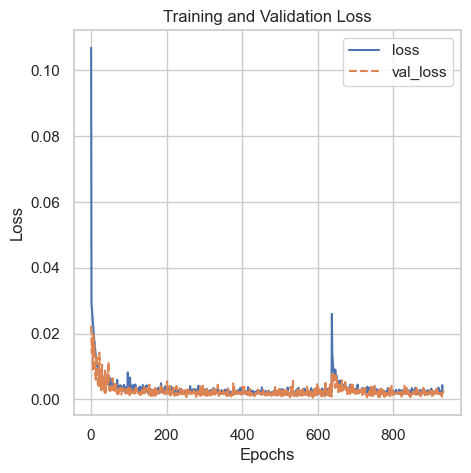

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
plt.grid(True)
my_plot = sns.lineplot(data = hist[['loss', 'val_loss']], ax = ax)
my_plot.set_xlabel('Epochs')
my_plot.set_ylabel('Loss')
my_plot.set_title('Training and Validation Loss')
leg = ax.legend()
leg_lines = leg.get_lines()
leg_lines[1].set_linestyle("dashed")
plt.show()